<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3583178993.py:26: SyntaxWarning: invalid escape sequence '\s'
  $$r = \frac{\sum(x_j - \bar{x}_j)(x_k - \bar{x}_k)}{\sqrt{\sum(x_j - \bar{x}_j)^2} \sqrt{\sum(x_k - \bar{x}_k)^2}}$$


FEATURE SELECTION PROCESS INITIALIZED
Threshold Criteria   : > 0.85
Selection Logic      : Iterative Variance Comparison (Drop Lower S.D.)
Initial Features (4) : ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
------------------------------------------------------------

--- INITIAL STATISTICS ---

[Correlation Matrix of All Features]:
                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)             1.0000            0.1176             0.8718   
sepal width (cm)              0.1176            1.0000             0.4284   
petal length (cm)             0.8718            0.4284             1.0000   
petal width (cm)              0.8179            0.3661             0.9629   

                   petal width (cm)  
sepal length (cm)            0.8179  
sepal width (cm)             0.3661  
petal length (cm)            0.9629  
petal width (cm)             1.0000  

[Standard Deviation (S.D.) of All Features]:
sepal

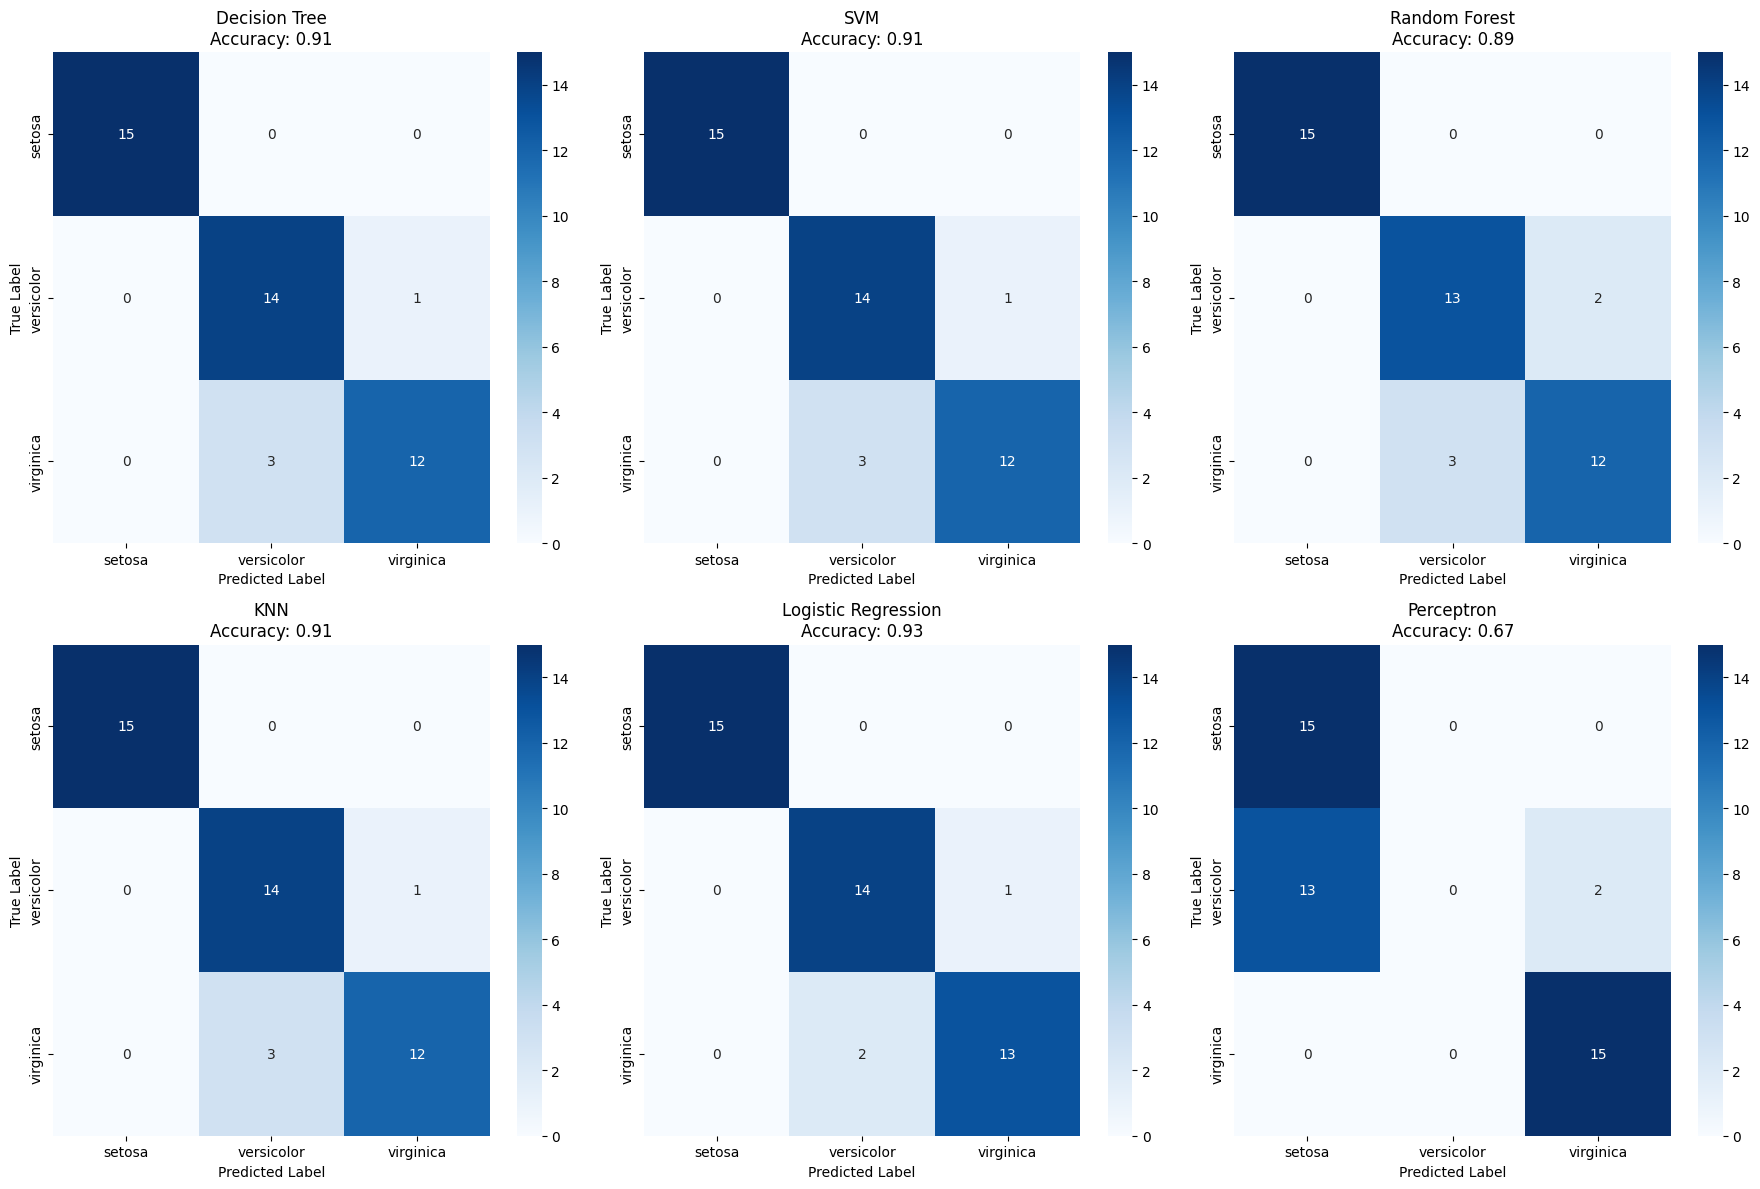

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data and metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Load models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron

# ==============================================================================
# Part 1: Mathematical Formulas (Manual Calculation)
# ==============================================================================

def calculate_manual_correlation(x_j, x_k):

    n = len(x_j)
    mean_j = np.mean(x_j)
    mean_k = np.mean(x_k)

    # Calculate Numerator (Covariance)
    numerator = np.sum((x_j - mean_j) * (x_k - mean_k))

    # Calculate Denominator (Product of Standard Deviations * n)
    sum_sq_j = np.sum((x_j - mean_j)**2)
    sum_sq_k = np.sum((x_k - mean_k)**2)
    denominator = np.sqrt(sum_sq_j) * np.sqrt(sum_sq_k)

    if denominator == 0:
        return 0

    return numerator / denominator

def get_manual_corr_matrix(df):
    """
    Generates Correlation Matrix using manual calculation.
    """
    features = df.columns
    n = len(features)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            val = calculate_manual_correlation(df.iloc[:, i].values, df.iloc[:, j].values)
            matrix[i, j] = abs(val)

    return pd.DataFrame(matrix, index=features, columns=features)

# ==============================================================================
# Part 2: Iterative Feature Selection Function (Formal Output)
# ==============================================================================

def iterative_feature_selection(df, threshold=0.85):

    current_df = df.copy()
    dropped_features = []

    print(f"{'='*60}")
    print(f"FEATURE SELECTION PROCESS INITIALIZED")
    print(f"{'='*60}")
    print(f"Threshold Criteria   : > {threshold}")
    print(f"Selection Logic      : Iterative Variance Comparison (Drop Lower S.D.)")
    print(f"Initial Features ({len(current_df.columns)}) : {list(current_df.columns)}")
    print(f"{'-'*60}\n")

    # --- Print Initial Statistics (Correlation & S.D.) ---
    print("--- INITIAL STATISTICS ---")

    # 1. Correlation Matrix
    corr_matrix = get_manual_corr_matrix(current_df)
    print("\n[Correlation Matrix of All Features]:")
    print(corr_matrix.round(4)) # Round to 4 decimal places for readability

    # 2. Standard Deviations
    print("\n[Standard Deviation (S.D.) of All Features]:")
    sd_values = current_df.std()
    print(sd_values.round(4))
    print(f"{'-'*60}\n")
    # -----------------------------------------------------

    iteration = 1

    while True:
        # 1. Calculate Correlation Matrix (Recalculate for current features)
        corr_matrix = get_manual_corr_matrix(current_df)

        # 2. Find location of largest value (mask diagonal)
        np.fill_diagonal(corr_matrix.values, 0)
        max_corr_val = corr_matrix.max().max()

        # 3. Check termination condition
        if max_corr_val < threshold:
            print(f"[*] TERMINATION CHECK: Max correlation {max_corr_val:.4f} is below threshold {threshold}.")
            print(f"    Process completed successfully.\n")
            break

        # Get feature pair
        row_name, col_name = corr_matrix.stack().idxmax()

        print(f"[ITERATION {iteration}] High Correlation Detected")
        print(f"   > Feature Pair      : '{row_name}' vs '{col_name}'")
        print(f"   > Correlation Coeff : {max_corr_val:.4f}")

        # 4. Compare Standard Deviation
        # Formula: $$s = \sqrt{\frac{1}{N-1} \sum_{i=1}^N (x_i - \bar{x})^2}$$
        std_row = current_df[row_name].std()
        std_col = current_df[col_name].std()

        print(f"   > S.D. Comparison   :")
        print(f"     - {row_name:<20} : {std_row:.4f}")
        print(f"     - {col_name:<20} : {std_col:.4f}")

        # 5. Drop feature with lower S.D.
        if std_row < std_col:
            drop_target = row_name
            keep_target = col_name
            reason = f"Lower S.D. ({std_row:.4f} < {std_col:.4f})"
        else:
            drop_target = col_name
            keep_target = row_name
            reason = f"Lower S.D. ({std_col:.4f} < {std_row:.4f})"

        print(f"   > ACTION            : DROP '{drop_target}'")
        print(f"   > Reason            : {reason}")
        print(f"{'-'*60}")

        # Drop column
        current_df = current_df.drop(columns=[drop_target])
        dropped_features.append(drop_target)
        iteration += 1

    print(f"{'='*60}")
    print(f"FINAL SUMMARY")
    print(f"{'='*60}")
    print(f"Total Features Dropped : {len(dropped_features)}")
    print(f"Dropped Features       : {dropped_features}")
    print(f"Remaining Features     : {list(current_df.columns)}")
    print(f"{'='*60}\n")

    return current_df

# ==============================================================================
# Part 3: Main Execution
# ==============================================================================

# 1. Load Data
iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
y = iris_data.target

# 2. Run Feature Selection
df_selected = iterative_feature_selection(df, threshold=0.85)

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df_selected, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Perceptron": Perceptron(max_iter=100, eta0=0.1, random_state=42)
}

# 5. Evaluate and Plot
plt.figure(figsize=(18, 12))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"Model Evaluation: {name}")
    print("-" * 30)
    # แสดงค่า Precision, Recall, F1-score
    print(classification_report(y_test, y_pred, target_names=iris_data.target_names, zero_division=0))
    print("-" * 30)
    print("\n")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=iris_data.target_names,
                yticklabels=iris_data.target_names)
    plt.title(f"{name}\nAccuracy: {acc:.2f}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()